In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
df = pd.read_csv(os.path.join("data", "processed", "all_data.csv"))
df.set_index("commune_id", inplace=True)
df.drop(columns=["name"], inplace=True)
vote_share_cols = [col for col in df.columns if col.startswith("vote_share_")]
df.drop(columns=vote_share_cols, inplace=True)

In [3]:
df_typo = df["typology"] # needed for stratification below
df = pd.get_dummies(df, columns=["language", "canton", "typology"])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df_typo)
X_train = df_train.drop(columns="po_value").values
y_train = df_train["po_value"].values
X_test = df_test.drop(columns="po_value").values
y_test = df_test["po_value"].values

print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}".format(y_train.shape))
print("X_test.shape = {}".format(X_test.shape))
print("y_test.shape = {}".format(y_test.shape))

X_train.shape = (1756, 87)
y_train.shape = (1756,)
X_test.shape = (440, 87)
y_test.shape = (440,)


In [4]:
gtbr = GradientBoostingRegressor(random_state=0)
print(gtbr.fit(X_train, y_train))
gtbr_test_pred = gtbr.predict(X_test)
print("With default params:")
print("GTBR MAE = {:.3f}".format(mean_absolute_error(y_test, gtbr_test_pred)))
print("GTBR R^2 = {:.3f}".format(gtbr.score(X_test, y_test)))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
With default params:
GTBR MAE = 0.155
GTBR R^2 = 0.739


In [5]:
parameters = {
    "learning_rate": [0.08, 0.09, 0.1, 0.11, 0.12 ],
    "n_estimators": np.linspace(100, 800, 8, dtype=int)
}
gcv = GridSearchCV(gtbr, parameters, scoring = "neg_mean_absolute_error", cv = 5, iid = False, n_jobs=12)
gcv.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best params = {}".format(gcv.best_params_))
print("Best MAE = {:.3f}".format(-gcv.best_score_))

Grid search / cross-validation:
Best params = {'learning_rate': 0.11, 'n_estimators': 600}
Best MAE = 0.153


In [6]:
gcv_test_pred = gcv.predict(X_test)
print("On test data:")
print("Tuned GTBR MAE = {:.3f}".format(mean_absolute_error(y_test, gcv_test_pred)))
print("Tuned GTBR R^2 = {:.3f}".format(r2_score(y_test, gcv_test_pred)))

On test data:
Tuned GTBR MAE = 0.150
Tuned GTBR R^2 = 0.759


In [7]:
parameters2 = {
    "learning_rate": [0.11],
    "n_estimators": [600],
    "max_depth": np.linspace(1, 10, 10, dtype=int),
    "min_samples_split": np.linspace(2, 10, 10, dtype=int)
}
gcv2= GridSearchCV(gtbr, parameters2, scoring = "neg_mean_absolute_error", cv = 5, iid = False, n_jobs=12)
gcv2.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best params = {}".format(gcv.best_params_))
print("Best MAE = {:.3f}".format(-gcv2.best_score_))

Grid search / cross-validation:
Best params = {'learning_rate': 0.11, 'n_estimators': 600}
Best MAE = 0.153


In [8]:
gcv2_test_pred = gcv2.predict(X_test)
print("On test data:")
print("Tuned GTBR MAE = {:.3f}".format(mean_absolute_error(y_test, gcv2_test_pred)))
print("Tuned GTBR R^2 = {:.3f}".format(r2_score(y_test, gcv2_test_pred)))

On test data:
Tuned GTBR MAE = 0.149
Tuned GTBR R^2 = 0.760


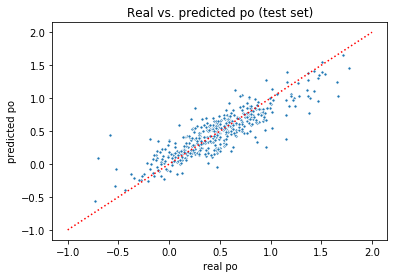

In [9]:
ax = sns.scatterplot(y_test, gcv2_test_pred, s=10)
ax.set_xlabel("real po")
ax.set_ylabel("predicted po")
ax.set_title("Real vs. predicted po (test set)")
ax.plot([-1, 2], [-1, 2], color="red", linestyle=":")
plt.show()